# Tensorflow Challenge: Speech to Text 

In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Embedding, Input, Dense, Conv1D, MaxPool1D, BatchNormalization, Dropout, Bidirectional,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
df=pd.DataFrame(columns=["File","Label"])
needed_labels=["yes","no","up","left","right","down",
              "one","two","three","four","five","six","seven","eight","nine"]
IND_SIZE=2000

In [3]:
labels=[]
filenames=[]
path='/kaggle/input/speech-commands-tensorflow/SpeechDataset/'
for label in needed_labels:
    if not os.path.isdir(path+label):
        continue
    for filename in os.listdir('/kaggle/input/speech-commands-tensorflow/SpeechDataset/'+label):
        filenames.append(filename)
        labels.append(label)
        if len(labels)%IND_SIZE==0:
            break

In [4]:
df=pd.DataFrame(data={"filenames":filenames,"labels":labels})

In [5]:
df=df.sample(frac=1)

In [6]:
df.head()

,filenames,labels
895,0a2b400e_nohash_3.wav,yes
9444,c22ebf46_nohash_3.wav,right
25158,538e1856_nohash_1.wav,seven
10420,1dc86f91_nohash_2.wav,down
26888,893705bb_nohash_13.wav,eight


In [7]:
df["labels"].value_counts()

three    2000
four     2000
down     2000
seven    2000
up       2000
right    2000
five     2000
six      2000
no       2000
eight    2000
left     2000
nine     2000
yes      2000
one      2000
two      2000
Name: labels, dtype: int64

In [8]:
example_file_path=df["labels"][0]+"/"+df["filenames"][0]

In [9]:
example_file_path

'yes/acfd5b5e_nohash_0.wav'

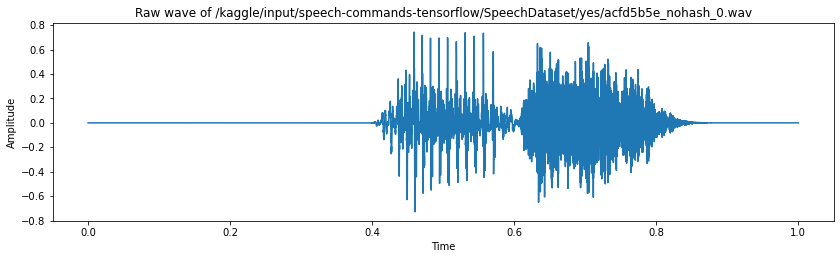

In [10]:
samples, sample_rate = librosa.load(path+example_file_path, sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + path + example_file_path)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, sample_rate), samples)

In [11]:
print(sample_rate)
ipd.Audio(samples, rate=sample_rate)

16000


In [12]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

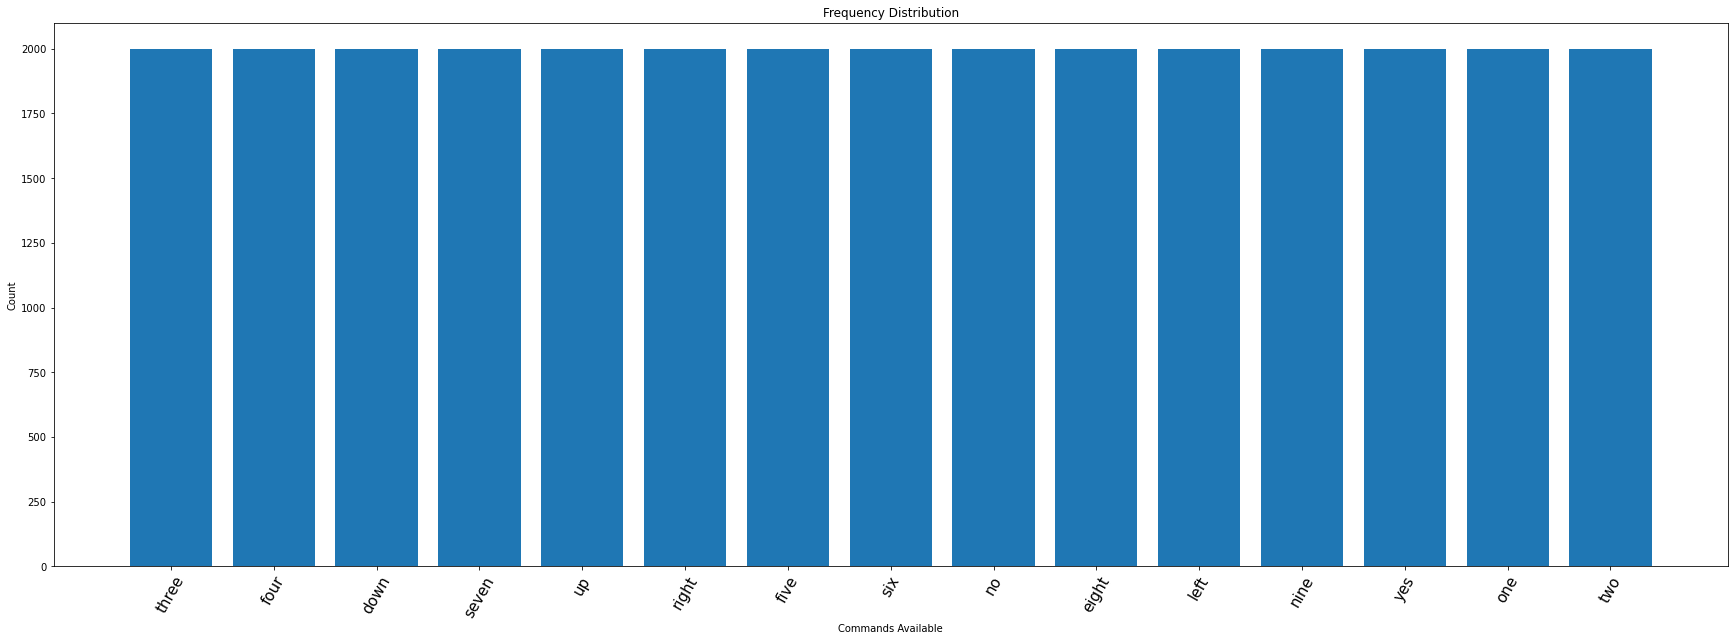

In [13]:
plt.figure(figsize=(30,10))
index=np.arange(len((df['labels'].value_counts().index)))
plt.bar(index,list(df['labels'].value_counts()[:]))
plt.xlabel('Commands Available')
plt.ylabel('Count')
plt.title('Frequency Distribution')
plt.xticks(index, df["labels"].value_counts().index, fontsize=15, rotation=60)
plt.show()

In [14]:
samples

array([1.9692132e-05, 4.2314532e-05, 3.9045488e-05, ..., 1.2277227e-05,
       4.7883209e-06, 1.4199108e-05], dtype=float32)

In [15]:
!apt install -y ffmpeg




ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 95 not upgraded.


In [16]:
all_samples=[]
all_labels=[]
for i in range(df.shape[0]):
    try:
        samples, sample_rate=librosa.load(path+df.iloc[i]["labels"]+"/"+df.iloc[i]["filenames"])
        re_sampled=librosa.resample(samples,sample_rate,8000)
        if re_sampled.shape[0]==8000:
            all_samples.append(re_sampled)
            all_labels.append(df.iloc[i]["labels"])
    except:
        continue

In [17]:
all_samples=np.array(all_samples)
all_labels=np.array(all_labels)

In [18]:
print(pd.value_counts(all_labels))

six      1859
nine     1846
five     1839
down     1835
left     1834
seven    1828
right    1827
three    1826
two      1821
four     1809
eight    1808
yes      1808
no       1805
one      1799
up       1751
dtype: int64


In [19]:
assert(len(needed_labels)==len(pd.value_counts(all_labels)))

In [20]:
np.save("samples_np.npy",all_samples)
np.save("all_labels_np.npy",all_labels)

In [21]:
#np.load('/kaggle/working/samples_np.npy')
#np.load('/kaggle/working/all_labels_np.npy')
all_samples=np.load('/kaggle/input/nlp-case-study-speech-to-text/samples_np.npy')
all_labels=np.load('/kaggle/input/nlp-case-study-speech-to-text/all_labels_np.npy')

In [22]:
all_labels

array(['four', 'five', 'five', ..., 'nine', 'down', 'right'], dtype='<U5')

In [23]:
time_steps=8000
lb=LabelEncoder()
all_samples=all_samples.reshape(-1,time_steps,1)
all_labels_int=lb.fit_transform(all_labels)
outcome_class=list(lb.classes_)
all_labels_one_hot=to_categorical(all_labels_int, num_classes=len(needed_labels))

In [24]:
all_labels_one_hot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [25]:
outcome_class

['down',
 'eight',
 'five',
 'four',
 'left',
 'nine',
 'no',
 'one',
 'right',
 'seven',
 'six',
 'three',
 'two',
 'up',
 'yes']

In [26]:
X_train, X_test, y_train, y_test= train_test_split(all_samples,all_labels_one_hot,test_size=0.2,random_state=42)

In [27]:
print("Size of training set: ",X_train.shape[0])
print("Size of testing set: ",X_test.shape[0])

Size of training set:  21790
Size of testing set:  5448


In [28]:
BATCH_SIZE=256
LR=1e-3
STEPS_PER_EPOCH=X_train.shape[0]//BATCH_SIZE
EPOCHS=200

In [29]:
#Models DeepSpeech2 and Wav2letter++ (From Facebook)
model=Sequential([
    Input(shape=(time_steps,1)),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True),
    
    Conv1D(8,13, padding='valid', activation='relu', strides=1),
    MaxPool1D(3),
    Dropout(0.3),
    
    Conv1D(16, 11, padding='valid', activation='relu', strides=1),
    MaxPool1D(3),
    Dropout(0.3),
    
    Conv1D(32, 9, padding='valid', activation='relu', strides=1),
    MaxPool1D(3),
    Dropout(0.3),
    
    BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True),
    
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    
    BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True),
    Flatten(),
    Dense(256,activation="relu"),
    Dense(len(outcome_class),activation='softmax')
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0

In [31]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(LR),metrics=['accuracy'])

In [32]:
#model.load_weights('/kaggle/input/nlp-case-study-speech-to-text/best_model.hdf5')

In [33]:
checkpoint=ModelCheckpoint('best_model.hdf5',monitor='val_accuracy',verbose=1, save_best_only=True,mode="max")

In [34]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[checkpoint],epochs=EPOCHS,batch_size=BATCH_SIZE,steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/200
85/85 [==============================] - ETA: 0s - loss: 5.6238 - accuracy: 0.0996
Epoch 00001: val_accuracy improved from -inf to 0.06443, saving model to best_model.hdf5
85/85 [==============================] - 27s 314ms/step - loss: 5.6238 - accuracy: 0.0996 - val_loss: 3.0528 - val_accuracy: 0.0644
Epoch 2/200
85/85 [==============================] - ETA: 0s - loss: 2.5720 - accuracy: 0.1115
Epoch 00002: val_accuracy improved from 0.06443 to 0.08076, saving model to best_model.hdf5
85/85 [==============================] - 24s 282ms/step - loss: 2.5720 - accuracy: 0.1115 - val_loss: 2.6962 - val_accuracy: 0.0808
Epoch 3/200
85/85 [==============================] - ETA: 0s - loss: 2.3796 - accuracy: 0.1653
Epoch 00003: val_accuracy improved from 0.08076 to 0.09563, saving model to best_model.hdf5
85/85 [==============================] - 24s 283ms/step - loss: 2.3796 - accuracy: 0.1653 - val_loss: 2.6768 - val_accuracy: 0.0956
Epoch 4/200
85/85 [===========================

In [35]:
def plot(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))
    plt.plot(epochs,acc)
    plt.plot(epochs,val_acc)
    plt.title('Training accuracy and Validation accuracy')
    plt.figure()
    plt.plot(epochs,loss)
    plt.plot(epochs,val_loss)
    plt.title('Training and validation loss')

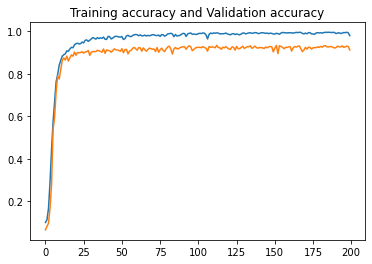

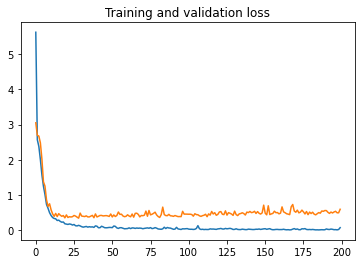

In [36]:
plot(history)

In [37]:
def predict(audio_s):
    probabilty=model.predict(audio_s.reshape(1,8000,1))
    index=np.argmax(probabilty[0])
    return outcome_class[index]

In [38]:
sample_rate=16000
rnd_i=np.random.randint(X_test.shape[0])
samples=X_test[rnd_i].ravel()
print("Audio:",outcome_class[np.argmax(y_test[rnd_i])])
print("Prediction from the model: ",predict(samples))

Audio: eight
Prediction from the model:  eight


In [39]:
ipd.Audio(samples, rate=8000)